<a href="https://colab.research.google.com/github/RoniAndarsyah/LSTM_NaiveBayesMultinomial/blob/master/LSTM_dan_NaiveBayesM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 4.4 MB/s 


Cari Datanya disini saya simpan di Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import time
import datetime
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import string, re
import itertools
import plotly.offline as py
import plotly.graph_objs as go
from collections import Counter

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from textblob import Word

# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, roc_curve, auc,accuracy_score,f1_score, classification_report
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, recall_score, precision_score


from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten,BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D,Conv1D, MaxPooling1D
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras.models import model_from_json
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, GRU, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.utils import to_categorical

py.init_notebook_mode(connected=True)

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

tf.random.set_seed(1234)

In [ ]:
import os
import numpy as np 
import pandas as pd 

Pastikan lokasinya sesuai ya, saya simpan d Folder LSTM pada GDRIVE silahkan ganti sesuai kebutuhan

In [ ]:
df=pd.read_csv('drive/MyDrive/LSTM/DATASET-excel.csv', encoding= 'unicode_escape')

In [ ]:
df.head()

,Komentar,Kategori,Unnamed: 2,Unnamed: 3
0,"""Kaka tidur yaa, udah pagi, gaboleh capek2""",Non-bullying,NaN,NaN
1,"""makan nasi padang aja begini badannya""",Non-bullying,NaN,NaN
2,"""yang aku suka dari dia adalah selalu cukur je...",Bullying,NaN,NaN
3,"""Hai kak Isyana aku ngefans banget sama kak Is...",Non-bullying,NaN,NaN
4,"""Manusia apa bidadari sih herann deh cantik te...",Non-bullying,NaN,NaN


In [ ]:
df.drop(['Unnamed: 2', 'Unnamed: 3'], inplace=True, axis=1)

In [ ]:
df.shape

(650, 2)

In [ ]:
df.Kategori.value_counts()

Non-bullying    325
Bullying        325
Name: Kategori, dtype: int64

Text Preprocessing: Stemming, Stop-Words removal and Lemmatization

In [ ]:
# function to clean the word in html tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,' ',sentence)
    return cleantext

# function to clean the word of any punctuation
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]', r'', sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r' ',cleaned)
    return cleaned

def words(text): return re.findall(r'\w+', text.lower())

In [31]:
factory = StemmerFactory()
ps = factory.create_stemmer()
factory = StopWordRemoverFactory()
stop= factory.get_stop_words()
stopwordlist=words(open('drive/MyDrive/LSTM/stopwords.txt').read())
stopword=stop+stopwordlist

Code for implementing step by step the checks mentioned in the preprocessing

In [ ]:
def preprocess_data(data):
    i=0
    str1= ' '
    final_string = []
    for sent in data['Komentar'].values:
        filtered_sentence = []
        sent = cleanhtml(sent)
        # remove html tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if ((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                    if (cleaned_words.lower() not in stopword):
                        s = (ps.stem(cleaned_words.lower()))
                        filtered_sentence.append(s)
                    else:
                        continue
                else:
                    continue
        str1 = " ".join(filtered_sentence) # final string of cleaned words

        final_string.append(str1)
        i+=1
    return final_string

In [32]:
df['Cleaned_text'] = preprocess_data(df) 

In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [34]:
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(20, 10))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")

In [35]:
word_cloud = WordCloud().generate(str(df['Cleaned_text']))

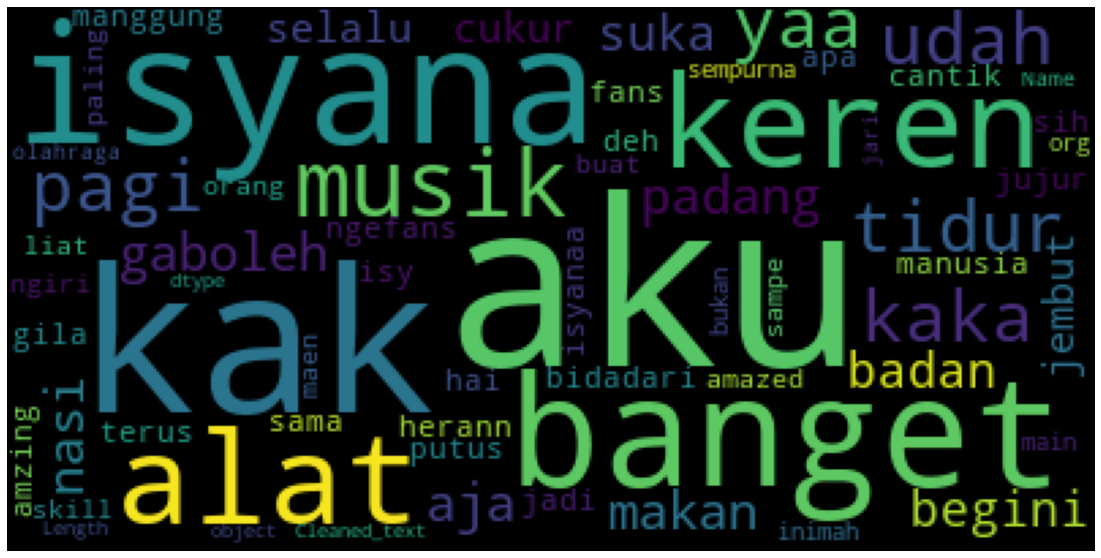

In [36]:
plot_cloud(word_cloud)

NEGATIVE WORDS

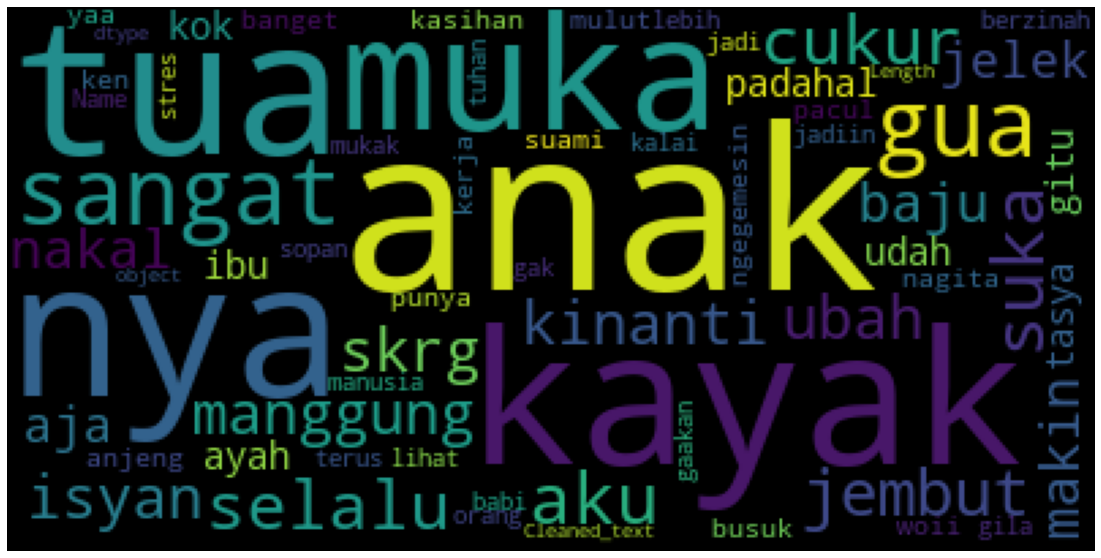

In [37]:
word_cloud = WordCloud().generate(str(df[df['Kategori'] == 'Bullying']['Cleaned_text']))
plot_cloud(word_cloud)

POSITIVE WORDS

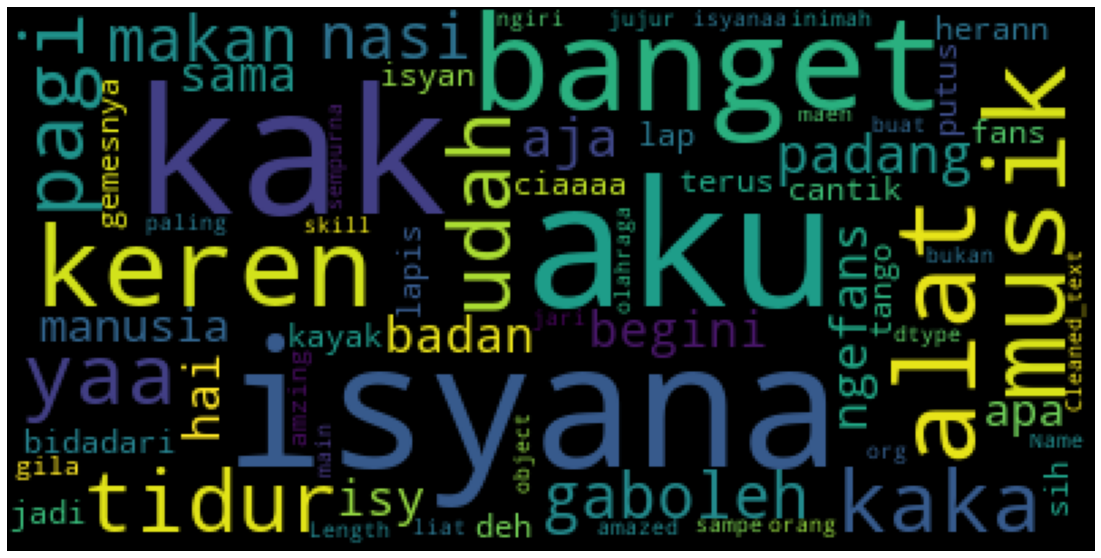

In [38]:
word_cloud = WordCloud().generate(str(df[df['Kategori'] == 'Non-bullying']['Cleaned_text']))
plot_cloud(word_cloud)

In [39]:
df['Kategori']

0      Non-bullying
1      Non-bullying
2          Bullying
3      Non-bullying
4      Non-bullying
           ...     
645    Non-bullying
646    Non-bullying
647    Non-bullying
648    Non-bullying
649    Non-bullying
Name: Kategori, Length: 650, dtype: object

In [40]:
def label(x):
    if x=='Non-bullying':
        return 0
    else:
        return 1

In [41]:
df['Kategori']=df['Kategori'].apply(label)

Split data into training and testing set

In [42]:
X_train, X_test, y_train, y_test = train_test_split(df['Cleaned_text'].values, df['Kategori'].values, test_size=0.3,random_state=42)

In [43]:
#initialize Tokenizer to encode strings into integers
train_df=df.copy()
tokenizer = Tokenizer()

# calculate number of rows in our dataset
num_rows = train_df.shape[0]

# create vocabulary from all words in our dataset for encoding
tokenizer.fit_on_texts(train_df['Cleaned_text'].values)

# max length of 1 row (number of words)
row_max_length = max([len(x.split()) for x in train_df['Cleaned_text'].values])

# count number of unique words
vocabulary_size = len(tokenizer.word_index) + 1

# convert words into integers
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

# ensure every row has same size - pad missing with zeros
X_train_pad = pad_sequences(X_train_tokens, maxlen=row_max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=row_max_length, padding='post')

Label Processiing

In [44]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

target_length = y_train_cat.shape[1]
print('Original vector size: {}'.format(y_train.shape))
print('Converted vector size: {}'.format(y_train_cat.shape))

Original vector size: (455,)
Converted vector size: (455, 2)


In [45]:
def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    plt.figure(figsize=(20, 5))

    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n', fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

   
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

**LSTM**

In [46]:
np.random.seed(1337)

print('Build model...')

vocabulary_size = len(tokenizer.word_index) + 1
row_max_length = max([len(x.split()) for x in df['Cleaned_text'].values])

EMBEDDING_DIM = 256

# LSTM
lstm_output_size = 70

model = Sequential()
model.add(Embedding(vocabulary_size, EMBEDDING_DIM, input_length=row_max_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(lstm_output_size))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(target_length, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_pad, y_train_cat, epochs=10, validation_data=(X_test_pad, y_test_cat), batch_size=2,shuffle=False)

Build model...
Epoch 1/10
228/228 [==============================] - 9s 28ms/step - loss: 0.6990 - accuracy: 0.4989 - val_loss: 0.6905 - val_accuracy: 0.5026
Epoch 2/10
228/228 [==============================] - 5s 22ms/step - loss: 0.5313 - accuracy: 0.8198 - val_loss: 0.5921 - val_accuracy: 0.7744
Epoch 3/10
228/228 [==============================] - 5s 22ms/step - loss: 0.3883 - accuracy: 0.8769 - val_loss: 0.6112 - val_accuracy: 0.7949
Epoch 4/10
228/228 [==============================] - 7s 32ms/step - loss: 0.3184 - accuracy: 0.9099 - val_loss: 0.6524 - val_accuracy: 0.7897
Epoch 5/10
228/228 [==============================] - 7s 30ms/step - loss: 0.2344 - accuracy: 0.9407 - val_loss: 0.7231 - val_accuracy: 0.7949
Epoch 6/10
228/228 [==============================] - 5s 23ms/step - loss: 0.1691 - accuracy: 0.9626 - val_loss: 0.6976 - val_accuracy: 0.8051
Epoch 7/10
228/228 [==============================] - 5s 24ms/step - loss: 0.1414 - accuracy: 0.9692 - val_loss: 0.8009 - val_a

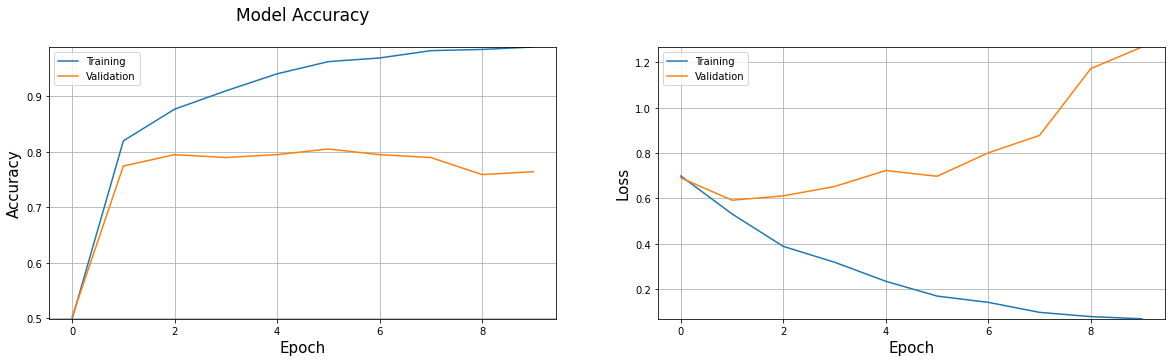

In [47]:
plot_performance(history=history)

In [48]:
y_pred_ = model.predict(X_test_pad)
y_pred = [np.argmax(x) for x in y_pred_]

In [49]:
print("Accuracy of the model : ", accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

Accuracy of the model :  0.764102564102564
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        98
           1       0.78      0.73      0.76        97

    accuracy                           0.76       195
   macro avg       0.77      0.76      0.76       195
weighted avg       0.77      0.76      0.76       195



In [50]:
cm_plot_labels = ['no_bully','bully']

In [51]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

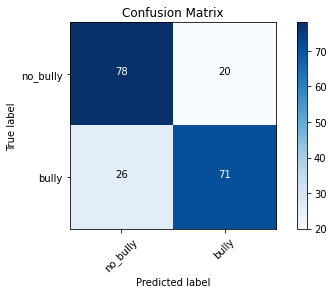

In [52]:
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

**Naive Bayes**

In [59]:
CountVec = CountVectorizer(ngram_range=(1,1), 
                           stop_words=stopword)
#transform
Count_data = CountVec.fit_transform(df['Cleaned_text'])
 
#create dataframe
X=pd.DataFrame(Count_data.toarray(),columns=CountVec.get_feature_names())
print(X)

     aamiin  abai  abis  abu  activity  adab  adam  adaptasi  adek  adeknya  \
0         0     0     0    0         0     0     0         0     0        0   
1         0     0     0    0         0     0     0         0     0        0   
2         0     0     0    0         0     0     0         0     0        0   
3         0     0     0    0         0     0     0         0     0        0   
4         0     0     0    0         0     0     0         0     0        0   
..      ...   ...   ...  ...       ...   ...   ...       ...   ...      ...   
645       0     0     0    0         0     0     0         0     0        0   
646       0     0     0    0         0     0     0         0     0        0   
647       0     0     0    0         0     0     0         0     0        0   
648       0     0     0    0         0     0     0         0     0        0   
649       0     0     0    0         0     0     0         0     0        0   

     ...  yaya  yayaaa  yehh  yesus  youtube  youtu